## 102p. 5.5 재현 (차분 도식화)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TimeSeriesForecasstingInPython/data/foot_traffic.csv')
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


In [ ]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['foot_traffic'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -1.1758885999240747
p-value: 0.683880891789619


In [ ]:
import numpy as np

foot_traffic_diff = np.diff(df['foot_traffic'], n = 1)
df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


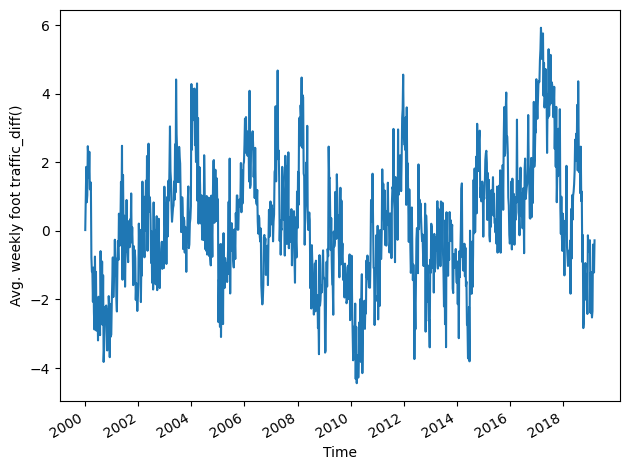

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Avg. weekly foot traffic_diff()')

# plt.xticks([0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
# ['2000', '2002', '2004', '2006', '2008', '2010', '2012', '2014', '2016', '2018'])
plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

## 115p. 5.6.1 AR(2) 프로세스 시뮬레이션하고 예측 수행하기

### 1. 이번 연습에서는 1,000개의 샘플을 생성

In [ ]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ma2 = np.array([1,0,0])
ar2 = np.array([1,-0.33,-0.50])

# AR2_process = ArmaProcess(ar2, ma2).generate_sample(nsample=1000)
AR3_process = ArmaProcess(ar2, ma2).generate_sample(nsample=10000)

### 2. 시뮬레이션한 자기회귀과정 도식화

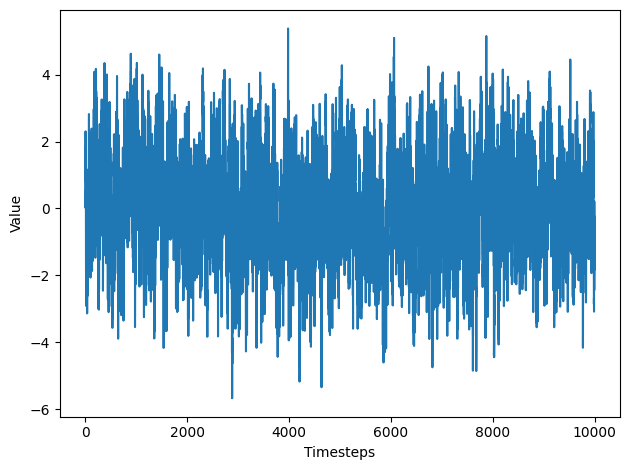

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# ax.plot(AR2_process)
ax.plot(AR3_process)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

### 3. ADF 테스트를 실행하고 프로세스가 정상적인지 확인

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF_result = adfuller(AR2_process)
ADF_result = adfuller(AR3_process)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -23.698151592182686
p-value: 0.0


### 4. ACF를 도식화하고 천천히 감쇄하고 있는지 확인

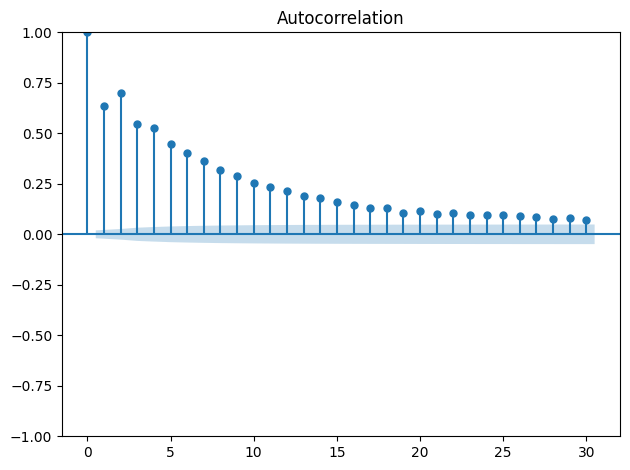

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# plot_acf(AR2_process, lags = 30)
plot_acf(AR3_process, lags = 30)

plt.tight_layout()

### 5. PCAF를 도식화하고 지연 2 이후 유의한 계수가 있는지 확인

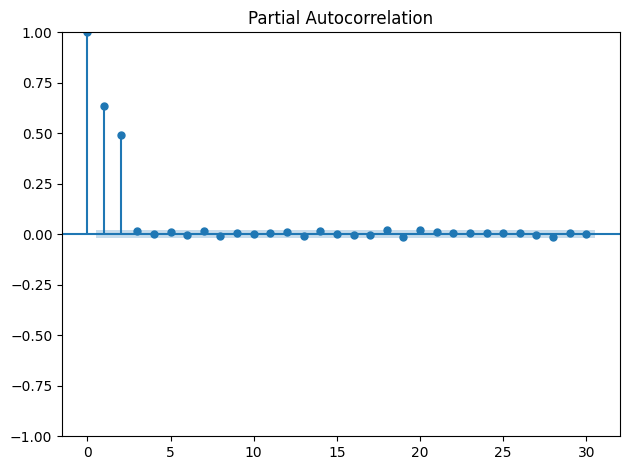

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# plot_pacf(AR2_process, lags = 30)
plot_pacf(AR3_process, lags = 30)

plt.tight_layout()

### 6. 시뮬레이션한 수열을 훈련 집합과 테스트 집합으로 분할 (800/200)

In [ ]:
# df = pd.DataFrame({'AR2_process':AR2_process})
df = pd.DataFrame({'AR3_process':AR3_process})

# train = df[:800]
# test = df[800:]
train = df[:8000]
test = df[8000:]

print(len(train))
print(len(test))
print(type(test))


8000
2000
<class 'pandas.core.frame.DataFrame'>


### 7. 테스트 집합에 대해 예측 수행

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df:pd.DataFrame, train_len: int, horizon: int,
                       window: int, method: str ) -> list:

  total_len = train_len + horizon

  # 평균값
  if method == 'mean':
    pred_mean = []

    for i in range(train_len, total_len, window):
      mean = np.mean(df[:i])
      pred_mean.extend(mean for _ in range(window))

    return pred_mean

  # 마지막 값
  elif method == 'last':
    pred_last_value = []

    for i in range(train_len, total_len, window):
      last_value = df[:i].iloc[-1].values[0]
      pred_last_value.extend(last_value for _ in range(window))

    return pred_last_value

  # AR(3)
  elif method == 'AR':
    pred_AR = []

    for i in range(train_len, total_len, window):
      model = SARIMAX(df[:i], order=(3,0,0))
      res = model.fit(disp=False)
      predictions = res.get_prediction(0, i + window - 1)
      oos_pred = predictions.predicted_mean[-window:]
      pred_AR.extend(oos_pred)

    return pred_AR[:horizon]

In [29]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW1 = 1
WINDOW2 = 2
WINDOW3 = 3
WINDOW4 = 4

# pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
# pred_last = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
#window값 1,2,3,4
pred_AR1 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW1, 'AR')
pred_AR2 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW2, 'AR')
pred_AR3 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW3, 'AR')
pred_AR4 = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW4, 'AR')

# pred_df['pred_mean'] = pred_mean
# pred_df['pred_last'] = pred_last
pred_df['pred_AR1'] = pred_AR1
pred_df['pred_AR2'] = pred_AR2
pred_df['pred_AR3'] = pred_AR3
pred_df['pred_AR4'] = pred_AR4

pred_df.head()

,AR3_process,pred_AR1,pred_AR2,pred_AR3,pred_AR4
8000,2.953885,2.924114,2.924114,2.924114,2.924114
8001,2.487558,2.982074,2.972818,2.972818,2.972818
8002,2.125462,2.322172,2.322172,2.458402,2.458402
8003,2.659913,1.954539,2.015691,1.954539,2.296732
8004,3.218359,1.931239,1.931239,1.712131,1.931239


### 8. 예측값 도식화

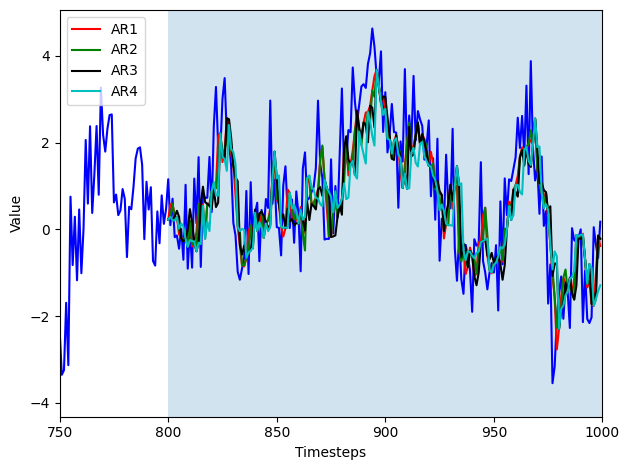

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(df['AR2_process'], 'b-')
ax.plot(range(800,1000), pred_df['pred_AR1'], 'r-', label='AR1')
ax.plot(range(800,1000), pred_df['pred_AR2'], 'g-', label='AR2')
ax.plot(range(800,1000), pred_df['pred_AR3'], 'k-', label='AR3')
ax.plot(range(800,1000), pred_df['pred_AR4'], 'c-', label='AR4')
# ax.plot(range(800,1000), pred_df['pred_mean'], 'g-', label='Mean')
# ax.plot(range(800,1000), pred_df['pred_last'], 'k-', label='Last value')

ax.axvspan(len(train), len(train) + len(test), alpha=0.2)
ax.legend(loc = 2)

plt.xlim(750, 1000)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')


plt.tight_layout()

### 9. MSE 측정 및 챔피언 모델 식별

In [ ]:
from sklearn.metrics import mean_squared_error

# mse_mean = mean_squared_error(test, pred_df['pred_mean'])
# mse_last = mean_squared_error(test, pred_df['pred_last'])
mse_AR1 = mean_squared_error(test, pred_df['pred_AR1'])
mse_AR2 = mean_squared_error(test, pred_df['pred_AR2'])
mse_AR3 = mean_squared_error(test, pred_df['pred_AR3'])
mse_AR4 = mean_squared_error(test, pred_df['pred_AR4'])

# print(mse_mean, mse_last, mse_AR)
print(mse_AR1, mse_AR2, mse_AR3, mse_AR4)

0.9323500289708793 0.9691013344883957 1.1674751941650623 1.2659672896745997


### 10. 막대형 도식으로 MSE 도식화

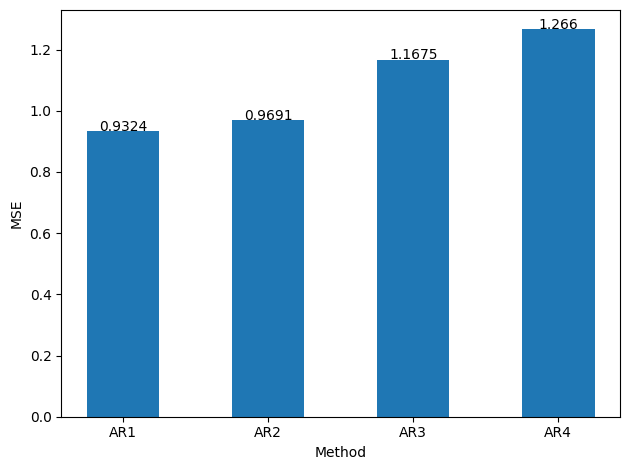

In [ ]:
fig, ax = plt.subplots()

# x = ['Mean', 'Last value', 'AR']
# y = [mse_mean, mse_last, mse_AR]

x = ['AR1', 'AR2', 'AR3', 'AR4']
y = [mse_AR1, mse_AR2, mse_AR3, mse_AR4]

ax.bar(x, y, width = 0.5)
ax.set_xlabel('Method')
ax.set_ylabel('MSE')

for index, value in enumerate(y):
  plt.text(x = index, y = value + 0.001, s = str(round(value, 4)), ha = 'center')

plt.tight_layout()